In [1]:
from Evolution.EvolutionaryLib import BaseChromosome, ChromosomeClassFactory
import random

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
from tqdm import tqdm

from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

In [2]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer(as_frame=True).frame
data

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.30010,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.16220,0.66560,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.08690,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.12380,0.18660,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.19740,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.14440,0.42450,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.24140,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.20980,0.86630,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.19800,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.13740,0.20500,0.4000,0.1625,0.2364,0.07678,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0.11590,0.24390,0.13890,0.1726,0.05623,...,26.40,166.10,2027.0,0.14100,0.21130,0.4107,0.2216,0.2060,0.07115,0
565,20.13,28.25,131.20,1261.0,0.09780,0.10340,0.14400,0.09791,0.1752,0.05533,...,38.25,155.00,1731.0,0.11660,0.19220,0.3215,0.1628,0.2572,0.06637,0
566,16.60,28.08,108.30,858.1,0.08455,0.10230,0.09251,0.05302,0.1590,0.05648,...,34.12,126.70,1124.0,0.11390,0.30940,0.3403,0.1418,0.2218,0.07820,0
567,20.60,29.33,140.10,1265.0,0.11780,0.27700,0.35140,0.15200,0.2397,0.07016,...,39.42,184.60,1821.0,0.16500,0.86810,0.9387,0.2650,0.4087,0.12400,0


In [3]:
X = data.iloc[:, :-1]
y = data.iloc[:, -1]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [4]:
class MyChromosome(BaseChromosome):
    def __init__(self):
        super().__init__()

    def crossover(self, other):
        new = MyChromosome()
        self.copy(new)
        
        new['max_depth'] = (self['max_depth'] + other['max_depth']) // 2
        new['learning_rate'] = random.choice([self['learning_rate'], other['learning_rate']])
        new['reg_lambda'] = random.choice([self['reg_lambda'], other['reg_lambda']])
        new['random_strength'] = (self['random_strength'] + other['random_strength']) // 2

        return new

    def mutate(self, rate=0.4):
        new = MyChromosome()
        self.copy(new)

        if random.random() < rate:
            new.max_depth = new._max_depth.get()
            new.learning_rate = new._learning_rate.get()
            new.reg_lambda = new._reg_lambda.get()
            new.random_strength = new._random_strength.get()
        else:
            new.max_depth = self.max_depth
            new.learning_rate = self.learning_rate
            new.reg_lambda = self.reg_lambda
            new.random_strength = self.random_strength
        
        return new

chromosome_factory = ChromosomeClassFactory(
    max_depth=list(range(1, 11)),
    learning_rate=[i * 0.01 for i in range(1, 101)],
    reg_lambda=[0.1, 0.2, 0.3, 0.4, 0.5],
    random_strength=list(range(0, 11)),
)

In [5]:
def evaluate(chromosome, show_metric=False):
    n_iterations = 3
    metric = 0
    for _ in range(n_iterations):
        model = CatBoostClassifier(
            iterations=100,
            max_depth=chromosome.max_depth,
            learning_rate=chromosome.learning_rate,
            reg_lambda=chromosome.reg_lambda,
            random_strength=chromosome.random_strength,
            verbose=False
        )
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        metric += accuracy_score(y_test, y_pred)
        
    metric /= n_iterations

    depth_penalty = abs(chromosome.max_depth - 5) * 0.01
    learning_rate_penalty = chromosome.learning_rate * 0.1
    lambda_penalty = chromosome.reg_lambda * 0.2
    random_strength_penalty = chromosome.random_strength * 0.05

    metric -= depth_penalty + learning_rate_penalty + lambda_penalty + random_strength_penalty

    if show_metric:
        print(f'{metric=}')

    return metric

In [6]:
# evolution hyperparameters initialisation 
POPULATION_SIZE = 30
ITERATIONS = 100
best = [None, -float('inf')]

In [7]:
# need for statistic collection 
statistic_best = []
statistic_mean = []

statistic_max_depth = []
statistic_learning_rate = []
statistic_reg_lambda = []
statistic_random_strength = []

# Evolutionary algorithm 

# initial population initialisation 
population = []
for _ in range(POPULATION_SIZE):
    c = chromosome_factory.generate(MyChromosome)
    population.append([c, None])

# evolution process 
for _ in tqdm(range(ITERATIONS)):
    # scoring each chromosome 
    for instance in population:
        if instance[1] is None:
            instance[1] = evaluate(instance[0])

    # selection of best instances 
    population = sorted(population, key=lambda x: x[1], reverse=True)[:POPULATION_SIZE // 3]

    statistic_best.append(population[0][1])
    statistic_mean.append(sum(map(lambda x: x[1], population)) / POPULATION_SIZE)

    statistic_max_depth.append(population[0][0].max_depth)
    statistic_learning_rate.append(population[0][0].learning_rate)
    statistic_reg_lambda.append(population[0][0].reg_lambda)
    statistic_random_strength.append(population[0][0].random_strength)

    # checking for the best solution 
    if population[0][1] > best[1]:
        best = population[0]
        print(best[0], f'{best[1]:_}', population[0][1], sep='\n')

    # filling the population with new genes 
    while len(population) < POPULATION_SIZE:
        r = random.random()
        if r < 0.33:
            population.append([random.choice(population)[0].crossover(random.choice(population)[0]), None])
        elif 0.33 <= r < 0.66:
            population.append([random.choice(population)[0].mutate(), None])
        else:
            population.append([chromosome_factory.generate(MyChromosome), None])

    if len(statistic_best) >= 10 and len(set(statistic_best[-10:])) == 1:
        print("The best result has not changed for the last 10 iterations. Ending the evolution process.")
        break

  0%|          | 0/100 [00:00<?, ?it/s]

  1%|          | 1/100 [02:18<3:47:55, 138.13s/it]

--Chromosome--
score: None
max_depth: 9
learning_rate: 0.11
reg_lambda: 0.4
random_strength: 1

0.7926842105263159
0.7926842105263159


  3%|▎         | 3/100 [05:54<2:55:35, 108.62s/it]

--Chromosome--
score: None
max_depth: 5
learning_rate: 0.01
reg_lambda: 0.2
random_strength: 0

0.9326842105263158
0.9326842105263158


 11%|█         | 11/100 [18:23<2:28:49, 100.33s/it]

The best result has not changed for the last 10 iterations. Ending the evolution process.


In [8]:
print(best[0], f'{best[1]:_}', sep='\n')
evaluate(best[0], True)
None

--Chromosome--
score: None
max_depth: 5
learning_rate: 0.01
reg_lambda: 0.2
random_strength: 0

0.9326842105263158


metric=0.9326842105263158


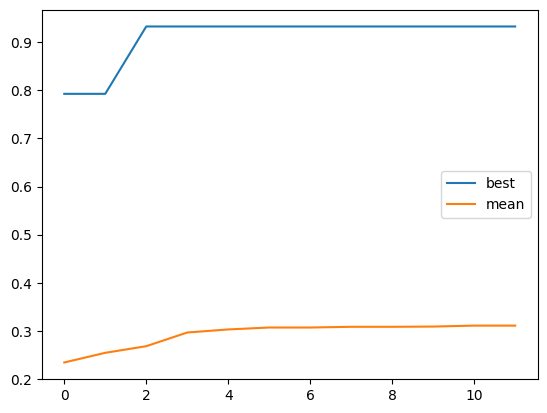

In [9]:
plt.plot(statistic_best, label="best")
plt.plot(statistic_mean, label="mean")
plt.legend()
plt.show()

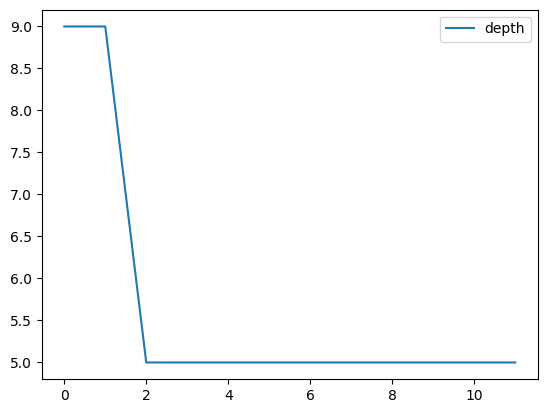

In [10]:
plt.plot(statistic_max_depth, label="depth")
plt.legend()
plt.show()

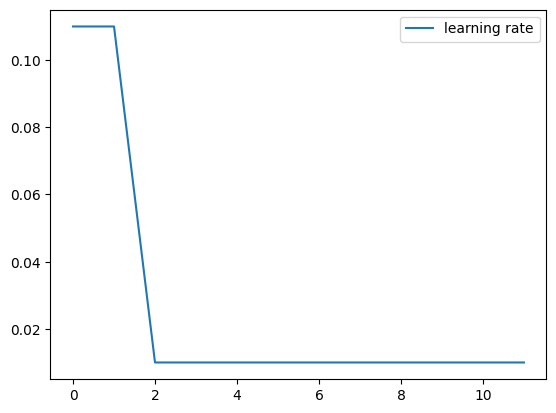

In [11]:
plt.plot(statistic_learning_rate, label="learning rate")
plt.legend()
plt.show()

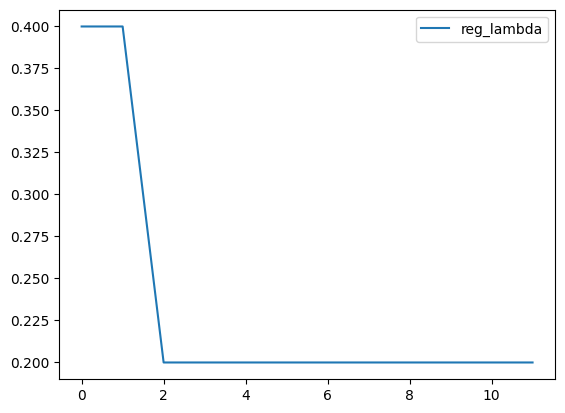

In [12]:
plt.plot(statistic_reg_lambda, label="reg_lambda")
plt.legend()
plt.show()

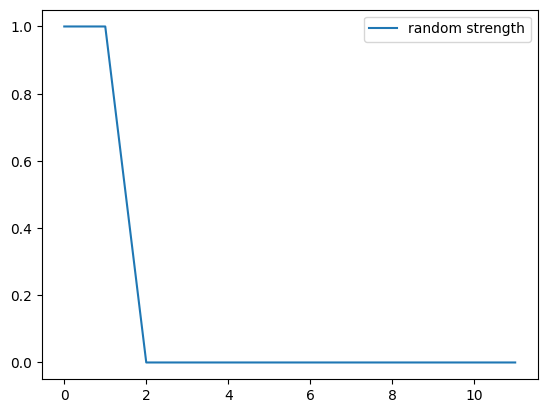

In [13]:
plt.plot(statistic_random_strength, label="random strength")
plt.legend()
plt.show()

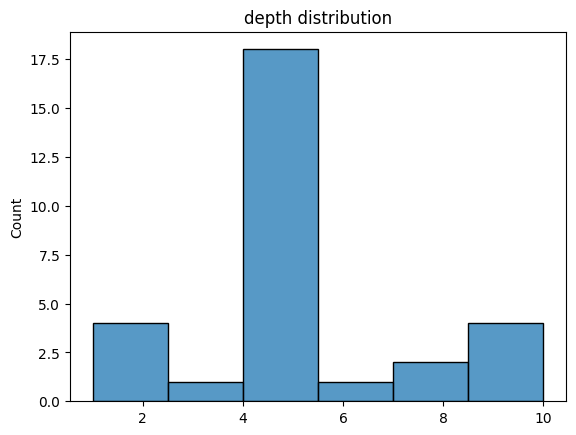

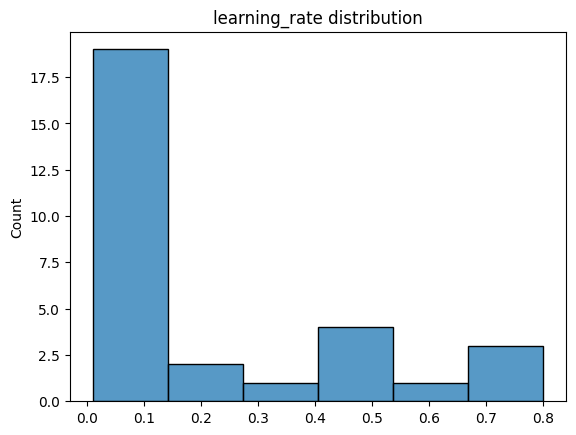

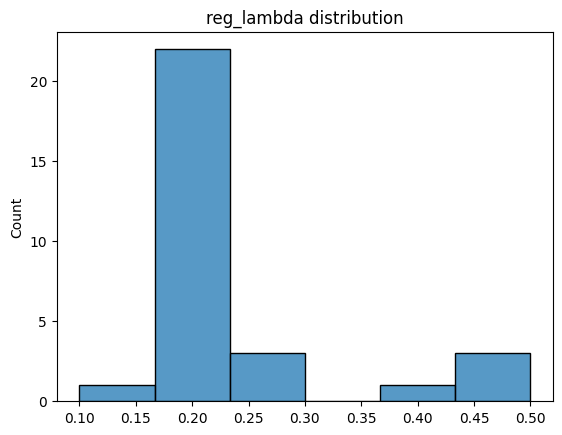

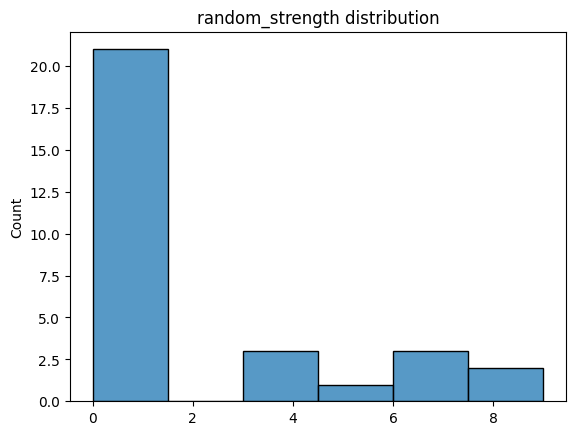

In [32]:
import seaborn as sns 

sns.histplot([c[0].max_depth for c in population])
plt.title('depth distribution')
plt.show()

sns.histplot([c[0].learning_rate for c in population])
plt.title('learning_rate distribution')
plt.show()

sns.histplot([c[0].reg_lambda for c in population])
plt.title('reg_lambda distribution')
plt.show()

sns.histplot([c[0].random_strength for c in population])
plt.title('random_strength distribution')
plt.show()